In [25]:
import os
import sys

# 自动检测环境
IS_KAGGLE = 'KAGGLE_KERNEL_RUN_TYPE' in os.environ
competition_name = 'competitions/titanic'

if IS_KAGGLE:
    print("Running on Kaggle")
    DATA_PATH = '/kaggle/input/' + competition_name
    OUTPUT_PATH = '/kaggle/working'
    # 可能需要安装包
else:
    print("Running locally")
    DATA_PATH = './data'
    OUTPUT_PATH = './output'

Running locally


In [26]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt



In [27]:
# Add src directory to Python path and import model
if IS_KAGGLE:
    !git clone https://github.com/catathome0410/Titanic_practice.git
    import sys
    sys.path.append('/kaggle/working/Titanic_practice/src')
else:
    sys.path.append('./src')

from model import log_R_solver, NN_solver

In [28]:
train = pd.read_csv(DATA_PATH + '/train.csv')
test = pd.read_csv(DATA_PATH + '/test.csv')
Y_train = np.array(train['Survived'])
train = train.drop(['Survived'], axis = 1)

In [ ]:
class Preprocessor_forT:
    def __init__(self):
        self.processor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), ['Age']),
                ('cat', OneHotEncoder(
                    sparse_output=False, 
                    handle_unknown='ignore',
                    dtype=np.int32), ['Pclass', 'Embarked', 'name_title', 'Cabin_class', 'Fare_class'])
            ],
            remainder='passthrough'
        )

    def has_alias(self, row):
        str0 = row['Name']
        return str0.find('(') >= 0 or str0.find('"') >=0

    def double_family_name(self, row):
        str0 = row['Name']
        loc0 = str0.find(', ')
        loc1 = str0.find(' ')
        return loc1 < loc0

    def find_title(self, row):
        str0 = row['Name']
        loc0 = str0.find(', ')
        loc1 = str0.find('. ')
        return str0[loc0+2 : loc1]

    ## Fare : < 10, <32, <90, <200
    def fare_class(self, row):
        if row['Fare'] < 10:
            res = 'low'
        elif row['Fare'] < 32:
            res = 'midlow'
        elif row['Fare'] < 90:
            res = 'mid'
        elif row['Fare'] < 200:
            res = 'midhigh'
        else:
            res = 'high'
        return res

    def cabin_class(self, row):
        if row['Cabin'].find(' ') >= 0:
            res = 'S'
        else:
            res = row['Cabin'][0]
        return res

    def clean_transform(self, df):
        df_train = df.copy()
        df_train['Embarked'] = df_train['Embarked'].fillna('S')
        df_train = df_train.drop(['Ticket'], axis = 1)
        df_train['name_title'] = df_train.apply(self.find_title, axis = 1)
        df_train['double_family_name'] = df_train.apply(self.double_family_name, axis = 1)
        df_train['has_alias'] = df_train.apply(self.has_alias, axis = 1)
        df_train['Age_present'] = df_train['Age'].isna() == False
        df_train['Age'] = df_train['Age'].fillna(0)
        df_train['name_title'] = df_train.apply(lambda row: row['name_title'] if row['name_title'] in ('Mr', 'Miss', 'Mrs', 'Master', 'Dr', 'Rev') else 'other', axis = 1)
        df_train['Cabin_present'] = df_train['Cabin'].isna() == False
        df_train['Fare_class'] = df_train.apply(self.fare_class, axis = 1)
        df_train['Cabin'] = df_train['Cabin'].fillna('None')
        df_train['Cabin_class'] = df_train.apply(self.cabin_class, axis = 1)
        df_train['Sex_male'] = df_train['Sex'] == 'male'
        df_train = df_train.drop(['Sex', 'Name', 'Cabin', 'PassengerId', 'Fare'], axis = 1)
        df_train = df_train.astype({
            'double_family_name': 'int32',
            'has_alias': 'int32',
            'Age_present': 'int32',
            'Cabin_present': 'int32',
            'Sex_male': 'int32',
        })

        return df_train
        
    def fit(self, df):
        df_processed = self.clean_transform(df)
        self.processor.fit(df_processed)

        return True

    def transform(self, df):
        df_processed = self.clean_transform(df)
        df_processed = self.processor.transform(df_processed)


        return df_processed

In [ ]:
prssr = Preprocessor_forT()
prssr.fit(train)
X_train = prssr.transform(train)
X_test = prssr.transform(test)


In [ ]:
n_pick_0 = np.floor(X_train.shape[0] / 16)
print(n_pick_0)
n_pick = 54 * 16

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=9, shuffle=True, random_state=42)

In [ ]:
# n_pick_arr = []
# avg_train_acc = []
# avg_dev_acc = []
# std_train_acc = []
# std_dev_acc = []

# for i in range(6):
#     n_pick = (i+1) * 9 * 16
#     # kf = KFold(n_splits=9, shuffle=True, random_state=42)
#     Xs = X_train[:n_pick, :]
#     Ys = Y_train[:n_pick]

#     kf = KFold(n_splits=9, shuffle=True)
#     model_accuracies_dev = []
#     model_accuracies_train = []

#     for train_idx, test_idx in kf.split(Xs):
#         Xss_train, Xss_test = Xs[train_idx], Xs[test_idx]
#         yss_train, yss_test = Ys[train_idx], Ys[test_idx]
        
#         model = log_R_solver(Xss_train, yss_train, alpha = 0.03, lambda2=0.01)
#         model.fit_L2()

#         y_train_pred = model.transfrom(Xss_train)
#         accuracy = np.sum(yss_train == y_train_pred) / yss_train.shape[0]
#         model_accuracies_train.append(accuracy)
        
#         y_test_pred = model.transfrom(Xss_test)
#         accuracy = np.sum(yss_test == y_test_pred) / yss_test.shape[0]
#         model_accuracies_dev.append(accuracy)

#     print(f"train 平均 accuracy: {np.mean(model_accuracies_train):.4f}")
#     print(f"train accuracy 标准差: {np.std(model_accuracies_train):.4f}")
#     print(f"dev 平均 accuracy: {np.mean(model_accuracies_dev):.4f}")
#     print(f"dev accuracy 标准差: {np.std(model_accuracies_dev):.4f}")

#     n_pick_arr.append(n_pick)
#     avg_train_acc.append(np.mean(model_accuracies_train))
#     avg_dev_acc.append(np.mean(model_accuracies_dev))
#     std_train_acc.append(np.std(model_accuracies_train))
#     std_dev_acc.append(np.std(model_accuracies_dev))


In [ ]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# # First subplot: y1 and y2
# ax1.plot(n_pick_arr, avg_train_acc, 'r-', linewidth=2, label='avg train acc')
# ax1.plot(n_pick_arr, avg_dev_acc, 'b--', linewidth=2, label='avg dev acc')
# ax1.set_xlabel('X axis', fontsize=12)
# ax1.set_ylabel('Y axis', fontsize=12)
# ax1.set_title('Plot 1: avg accuracy', fontsize=14)
# ax1.legend(fontsize=11)
# ax1.grid(True, alpha=0.3)

# # Second subplot: y3 and y4
# ax2.plot(n_pick_arr, std_train_acc, 'r-', linewidth=2, label='std train acc')
# ax2.plot(n_pick_arr, std_dev_acc, 'b--', linewidth=2, label='std dev acc')
# ax2.set_xlabel('X axis', fontsize=12)
# ax2.set_ylabel('Y axis', fontsize=12)
# ax2.set_title('Plot 2: std accuracy', fontsize=14)
# ax2.legend(fontsize=11)
# ax2.grid(True, alpha=0.3)

# fig.suptitle('alpha = 0.03, lambda2=0.01')
# plt.tight_layout()
# plt.show()

In [ ]:
# model_accuracies

In [ ]:
# LgR_model = log_R_solver(X_train, Y_train, alpha = 0.02, lambda2=0.01)
# LgR_model.fit_L2()

In [ ]:
# y_res_logr = LgR_model.transfrom(X_test)
# df_test_for_o = test.copy()
# df_test_for_o['Survived'] = y_res_logr
# df_res = df_test_for_o[['PassengerId', 'Survived']]
# df_res.to_csv(OUTPUT_PATH + 'v12_after_bv.csv', index=False, encoding='utf-8')


In [ ]:
if IS_KAGGLE == False:
    os.makedirs('output', exist_ok=True)


In [ ]:
# df_res = df_test[['PassengerId', 'Survived']]
# df_res.to_csv(OUTPUT_PATH + '/v4_l2_reg.csv', index=False, encoding='utf-8')

In [ ]:
n_pick_0 = np.floor(X_train.shape[0] / 16)
print(n_pick_0)
n_pick = 54 * 16
Xs = X_train[:n_pick, :]
Ys = Y_train[:n_pick]

In [ ]:
n_pick_arr = []
avg_train_acc = []
avg_dev_acc = []
std_train_acc = []
std_dev_acc = []

for i in range(6):
    n_pick = (i+1) * 9 * 16
    Xs = X_train[:n_pick, :]
    Ys = Y_train[:n_pick]

    # kf = KFold(n_splits=9, shuffle=True, random_state=42)
    kf = KFold(n_splits=9, shuffle=True)
    model_accuracies_dev = []
    model_accuracies_train = []

    for train_idx, test_idx in kf.split(Xs):
        Xss_train, Xss_test = Xs[train_idx], Xs[test_idx]
        yss_train, yss_test = Ys[train_idx], Ys[test_idx]
        
        model = NN_solver(Xss_train, yss_train, alpha=0.03, n_seed = 200, output_gap = 100)
        model.fit_shallow_parallel(shallow_iter_limit = 2000, target_loss = 320)

        n_min_seed = model.loss_arr.argmin()
        model.fit_deep(10000, lr_raito = 0.1, use_input = True, W1_i=model.W1[:, :, n_min_seed], b1_i=model.b1[:, :, n_min_seed], W2_i=model.W2[:, :, n_min_seed], b2_i=model.b2[:, :, n_min_seed], W3_i=model.W3[:, :, n_min_seed], b3_i=model.b3[:, :, n_min_seed])
        
        accuracy = model.check_performance(Xss_test, yss_test)
        model_accuracies_dev.append(accuracy)

        accuracy = model.check_performance(Xss_train, yss_train)
        model_accuracies_train.append(accuracy)

    n_pick_arr.append(n_pick)
    avg_train_acc.append(np.mean(model_accuracies_train))
    avg_dev_acc.append(np.mean(model_accuracies_dev))
    std_train_acc.append(np.std(model_accuracies_train))
    std_dev_acc.append(np.std(model_accuracies_dev))



In [ ]:
df = pd.DataFrame({
    'n_data': n_pick_arr,
    'avg_train_accuracy': avg_train_acc,
    'avg_dev_accuracy': avg_dev_acc,
    'std_train_accuracy': std_train_acc,
    'std_dev_accuracy': std_dev_acc
})

df.to_csv('nn_acc_curve_a003.csv', index=False, encoding='utf-8')


In [ ]:
# y_res_logr = nslr.predict(X_test)
# df_test_for_o = test.copy()
# df_test_for_o['Survived'] = y_res_logr
# df_res = df_test_for_o[['PassengerId', 'Survived']]
# df_res.to_csv(OUTPUT_PATH + 'v14_nn_new_feature.csv', index=False, encoding='utf-8')

In [ ]:
# 就 NN的效果来说已经很好了，接下来要提升titanic 的数据效果是ML hyper parametr tuning 和feature engineering 方面的工作
    
    ## K-fold training, (check)
    ## Roc curve, precision / recall 
## 把Titanic 剩下的几个feature 挖出点东西来. Name / Cabin / 
## Bias / Variance curve
## NN variance tuning, 剪枝，regularization, early stopping 这些

In [ ]:
# df_bv_curve = pd.read_csv(OUTPUT_PATH + '/nn_acc_curve_a001.csv')
# df_bv_curve

,n_data,avg_train_accuracy,avg_dev_accuracy,std_train_accuracy,std_dev_accuracy
0,144,0.940972,0.763889,0.014316,0.137493
1,288,0.901910,0.718750,0.009647,0.062500
2,432,0.895833,0.784722,0.006138,0.043921
3,576,0.887587,0.774306,0.010542,0.063410
4,720,0.883160,0.795833,0.008801,0.032275
5,864,0.882957,0.791667,0.007702,0.048113


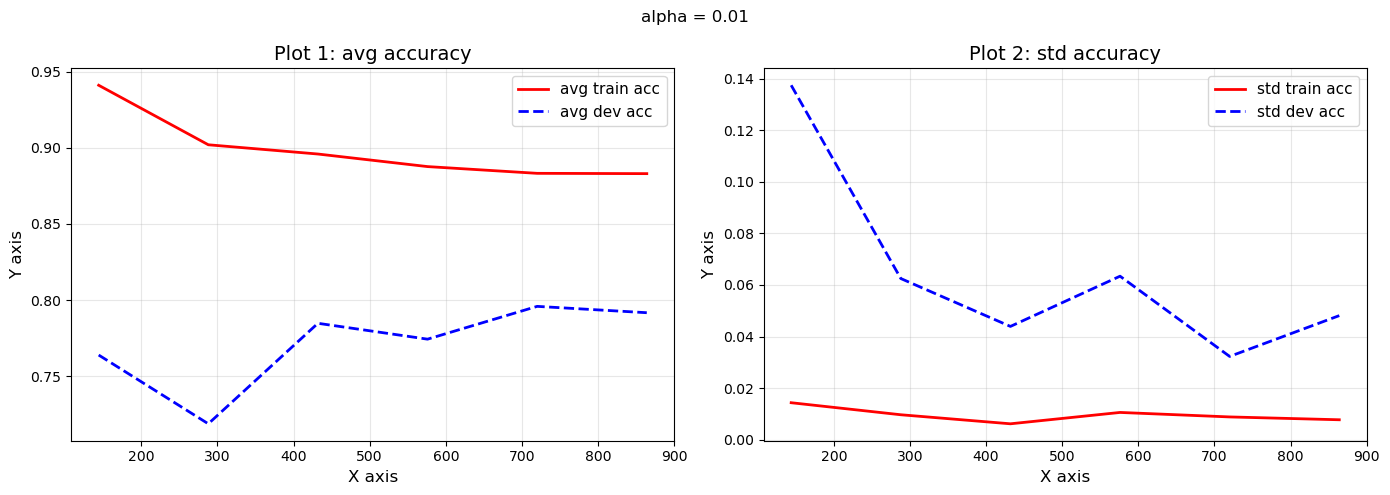

In [ ]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# # First subplot: y1 and y2
# ax1.plot(df_bv_curve[['n_data']], df_bv_curve[['avg_train_accuracy']], 'r-', linewidth=2, label='avg train acc')
# ax1.plot(df_bv_curve[['n_data']], df_bv_curve[['avg_dev_accuracy']], 'b--', linewidth=2, label='avg dev acc')
# ax1.set_xlabel('X axis', fontsize=12)
# ax1.set_ylabel('Y axis', fontsize=12)
# ax1.set_title('Plot 1: avg accuracy', fontsize=14)
# ax1.legend(fontsize=11)
# ax1.grid(True, alpha=0.3)

# # Second subplot: y3 and y4
# ax2.plot(df_bv_curve[['n_data']], df_bv_curve[['std_train_accuracy']], 'r-', linewidth=2, label='std train acc')
# ax2.plot(df_bv_curve[['n_data']], df_bv_curve[['std_dev_accuracy']], 'b--', linewidth=2, label='std dev acc')
# ax2.set_xlabel('X axis', fontsize=12)
# ax2.set_ylabel('Y axis', fontsize=12)
# ax2.set_title('Plot 2: std accuracy', fontsize=14)
# ax2.legend(fontsize=11)
# ax2.grid(True, alpha=0.3)

# fig.suptitle('alpha = 0.01')
# plt.tight_layout()
# plt.show()